In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
from math import *
import glob
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Подгружаем таблицы с данными и сводим их в единую таблицу по опционам
names = glob.glob(r'/content/drive/MyDrive/Андан Проект/Данные опционы/*.xlsx',\
                  recursive=True)
cont = []
for i in range(len(names)):
    df = pd.read_excel(names[i], index_col=0)
    cont.append(df)
totaldata = pd.concat(cont)
df_options = totaldata.reset_index()

In [ ]:
df_options.isnull().sum()

,0
transact_time,0
price,0
size,0
osi_root,38
expire_date,0
call_put_flag,38
strike_price,0
spread,0


In [ ]:
 # Пропусков не так много, поэтому убираем строки со значением NAN
df_options = totaldata.reset_index().dropna()

In [ ]:
# Удаляем цифру в начале названия тикера, т.к. цифра означает биржу,
# на которой был "listed" опцион (2 - Нью-Йоркская биржа, 4 - Чикагская)
df_options['ticker'] = df_options['osi_root'].apply(lambda x: x[1:])
df_options.drop(columns=['osi_root'], inplace=True)

# неинформативное значение
df_options = df_options.drop('spread', axis=1)

In [ ]:
display(df_options['price'].describe(), df_options['size'].describe(),\
        df_options['strike_price'].describe())

,price
count,23634.000000
mean,168.781258
std,761.806840
min,0.010000
25%,1.620000
50%,11.730000
75%,65.450000
max,20706.000000


,size
count,23634.000000
mean,566.925362
std,3157.606639
min,1.000000
25%,3.000000
50%,22.000000
75%,125.000000
max,116382.000000


,strike_price
count,23634.000000
mean,1291.109111
std,2979.701949
min,0.010000
25%,88.000000
50%,473.370000
75%,605.480000
max,27246.320000


In [ ]:
df_options['ticker'].value_counts().head(5)

,count
ticker,
SPY,11498
SPX,2718
QQQ,1462
IWM,956
MSTR,740


In [ ]:
# Оставляем 3 самых значимых по вкладу тикера
df_options = df_options[df_options['ticker'].isin(['SPY', 'SPX', 'QQQ'])]

In [ ]:
# Добавляем один час к времени, чтобы иметь возможность в будущем сравнивать
# одновременные торги на Чикагской бирже опционов (UTC -6)
# и торги акций на бирже в Нью-Йорке (UTC -5)
df_options['transact_time'] = df_options['transact_time'] +\
 pd.Timedelta(hours=1)

In [ ]:
# После удаления тикеров с небольшими объемами, пересоздаем индекс
df_options = df_options.reset_index()
df_options.drop(columns=['index'], inplace=True)

# Рассчитаем время до даты эксперации

In [ ]:
df_options['time_before_expire_date'] = df_options['expire_date'] -\
df_options['transact_time'].apply(lambda x: x.floor('min'))

In [ ]:
# Найдем объем в долларах купленных опционов
df_options['buy_volume'] = df_options['price'] * df_options['size']

In [ ]:
df_options['buy_volume'].describe().round(2)

,buy_volume
count,15678.00
mean,12597.03
std,156953.58
min,0.01
25%,29.20
50%,229.23
75%,1210.36
max,7131605.40


In [ ]:
df_options.head()

,transact_time,price,size,expire_date,call_put_flag,strike_price,ticker,time_before_expire_date,buy_volume
0,2025-02-20 09:55:35.778,33.02,2,2026-05-20,P,610.40,SPY,453 days 14:05:00,66.04
1,2025-02-20 09:55:35.778,600.21,2,2026-05-20,C,0.01,SPY,453 days 14:05:00,1200.42
2,2025-02-20 09:55:35.778,6.17,2,2026-05-20,P,427.28,SPY,453 days 14:05:00,12.34
3,2025-02-20 09:55:35.778,18.43,2,2026-05-20,C,678.15,SPY,453 days 14:05:00,36.86
4,2025-02-20 09:55:35.778,6.17,2,2026-05-20,P,427.28,SPY,453 days 14:05:00,12.34


<Axes: >

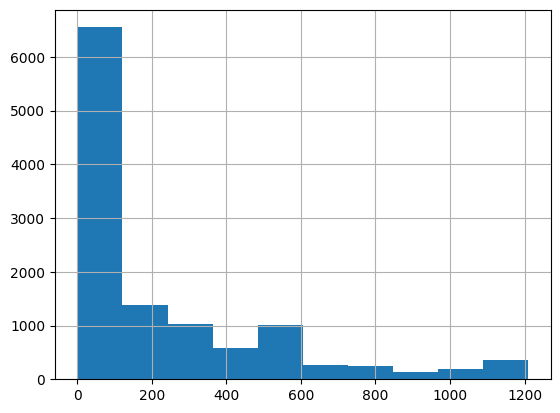

In [ ]:
#Построение графика плотности распределения объемов торгов по индексам
df_options['buy_volume'][df_options['buy_volume'] <\
                         df_options['buy_volume'].quantile(0.75)].hist()